In [23]:
import numpy as np
import pandas as pd
pd.set_option('max_rows',38)
pd.set_option('max_columns',25)
import time
import pickle
from tqdm import tqdm
import myslack_incomming

# model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras.layers import Activation, BatchNormalization
import xgboost
from scipy.sparse import csr_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn import preprocessing
from keras.models import load_model

# Ver 1

# Data Check

#### - train.csv

In [2]:
train = pickle.load(open("./data/final_train_Ver1.pkl", "rb"))
print("test data shape: "+str(train.shape))

test data shape: (95674, 5482)


#### - test.csv

In [3]:
test = pickle.load(open("./data/final_test_Ver1.pkl", "rb"))
print("test data shape: "+str(test.shape))

test data shape: (95674, 5481)


#### - sample_submission.csv

In [4]:
samplesub = pd.read_csv("./data/sample_submission.csv")
print("sample_submission data shape: "+str(samplesub.shape))

sample_submission data shape: (95674, 39)


---

# Modeling 8 - Neural Network

### Train_X, Train_y

In [5]:
X = train.drop(columns='TripType')
y = train['TripType']

In [6]:
len(y.unique()), y.unique()

(38, array([999,  30,  26,   8,  35,  41,  21,   6,  42,   7,   9,  39,  25,
         38,  15,  36,  20,  37,  32,  40,   5,   3,   4,  24,  33,  43,
         31,  27,  34,  18,  29,  44,  19,  23,  22,  28,  14,  12]))

In [7]:
y.unique()

array([999,  30,  26,   8,  35,  41,  21,   6,  42,   7,   9,  39,  25,
        38,  15,  36,  20,  37,  32,  40,   5,   3,   4,  24,  33,  43,
        31,  27,  34,  18,  29,  44,  19,  23,  22,  28,  14,  12])

In [8]:
preprocessing.LabelEncoder().fit_transform(y.unique())

array([37, 22, 18,  5, 27, 33, 13,  3, 34,  4,  6, 31, 17, 30,  9, 28, 12,
       29, 24, 32,  2,  0,  1, 16, 25, 35, 23, 19, 26, 10, 21, 36, 11, 15,
       14, 20,  8,  7])

In [9]:
train['TripType'].replace(y.unique(),preprocessing.LabelEncoder().fit_transform(y.unique()),inplace=True)

In [10]:
len(y.unique()), y.unique()

(38, array([37, 22, 18,  5, 27, 33, 13,  3, 34,  4,  6, 31, 17, 30,  9, 28, 12,
        29, 24, 32,  2,  0,  1, 16, 25, 35, 23, 19, 26, 10, 21, 36, 11, 15,
        14, 20,  8,  7]))

In [11]:
X = csr_matrix(X); X

<95674x5481 sparse matrix of type '<class 'numpy.int64'>'
	with 1124112 stored elements in Compressed Sparse Row format>

In [12]:
csr_test = csr_matrix(test); csr_test

<95674x5481 sparse matrix of type '<class 'numpy.int64'>'
	with 1130483 stored elements in Compressed Sparse Row format>

## Keras

### Train Test Split

In [24]:
X_train, X_test, y_train0, y_test0 = train_test_split(X, y, test_size=0.2)

X_train.shape[0], X_test.shape[0], len(y_train0), len(y_test0)

(76539, 19135, 76539, 19135)

In [52]:
Y_train = np_utils.to_categorical(y_train0, 38)
Y_test = np_utils.to_categorical(y_test0, 38)

In [53]:
dense = 100
lr = 0.001

In [54]:
NN_model_Adam = Sequential()
NN_model_Adam.add(Dense(dense, input_dim=5481, kernel_initializer="glorot_uniform"))
NN_model_Adam.add(BatchNormalization())
NN_model_Adam.add(Activation('relu'))
NN_model_Adam.add(Dense(38, activation="softmax", kernel_initializer="glorot_uniform"))
NN_model_Adam.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=["accuracy"])

In [55]:
NN_model_Adam.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               548200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 38)                3838      
Total params: 552,438
Trainable params: 552,238
Non-trainable params: 200
_________________________________________________________________


In [56]:
epochs = 20
batch_size = 5000

In [57]:
%%time
hist = NN_model_Adam.fit(X_train, Y_train, 
                              epochs=epochs, batch_size=batch_size, 
                              validation_data=(X_test, Y_test), 
                              verbose=1)

myslack_incomming.send_slack('Adam finish! dense: {}, lr: {},  val_acc: {} '
                             .format(dense,lr,hist.history['val_acc'][-1]))

Train on 76539 samples, validate on 19135 samples
Epoch 1/20
76539/76539 [==============================] - 5s 70us/step - loss: 0.1087 - acc: 0.9742 - val_loss: 0.0961 - val_acc: 0.9747
Epoch 2/20
76539/76539 [==============================] - 5s 62us/step - loss: 0.0825 - acc: 0.9753 - val_loss: 0.0790 - val_acc: 0.9759
Epoch 3/20
76539/76539 [==============================] - 5s 64us/step - loss: 0.0643 - acc: 0.9780 - val_loss: 0.0682 - val_acc: 0.9773
Epoch 4/20
76539/76539 [==============================] - 5s 62us/step - loss: 0.0525 - acc: 0.9815 - val_loss: 0.0607 - val_acc: 0.9794
Epoch 5/20
76539/76539 [==============================] - 5s 64us/step - loss: 0.0448 - acc: 0.9843 - val_loss: 0.0556 - val_acc: 0.9809
Epoch 6/20
76539/76539 [==============================] - 5s 64us/step - loss: 0.0394 - acc: 0.9863 - val_loss: 0.0520 - val_acc: 0.9820
Epoch 7/20
76539/76539 [==============================] - 6s 72us/step - loss: 0.0352 - acc: 0.9879 - val_loss: 0.0495 - val_acc

### Confusion Matrix

In [58]:
Y_test.argmax(axis=1)

array([ 5, 32, 32, ..., 30, 29, 22])

In [59]:
y_pred

array([5, 5, 5, ..., 5, 5, 5])

In [60]:
y_pred = NN_model_Adam.predict_classes(X_test)
confusion_matrix(Y_test.argmax(axis=1), y_pred)

array([[ 707,    0,    3, ...,    0,    0,   12],
       [   1,   49,    5, ...,    0,    0,    0],
       [   0,    1,  799, ...,    0,    1,    7],
       ...,
       [   4,    1,    2, ...,   11,    4,    4],
       [   0,    0,    1, ...,    8,   50,    3],
       [  65,    4,   12, ...,    1,    0, 1390]])

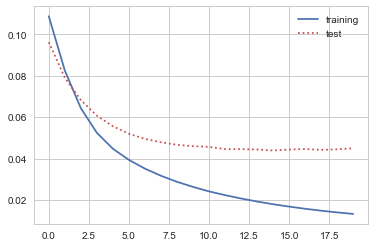

In [61]:
plt.plot(hist.history['loss'], 'b-', label="training")
plt.plot(hist.history['val_loss'], 'r:', label="test")
plt.legend()
plt.show()

In [67]:
'val_loss: '+str(hist.history['val_loss'][-1])

'val_loss: 0.044994258006675954'

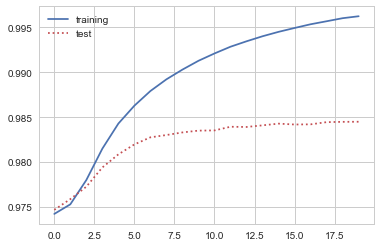

In [63]:
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

In [62]:
'val_acc: '+str(hist.history['val_acc'][-1])

'val_acc: 0.9844983059524525'

### prediction

In [64]:
result = NN_model_Adam.predict_proba(csr_test)
result

array([[2.4456100e-03, 4.1931446e-05, 1.3068995e-03, ..., 6.5463231e-05,
        2.7578573e-05, 3.2642376e-01],
       [2.5831402e-04, 2.3646130e-06, 1.0158200e-04, ..., 3.6625192e-04,
        2.9472489e-04, 3.1441925e-04],
       [2.6412145e-03, 2.7463942e-05, 1.4796653e-03, ..., 9.8326556e-05,
        1.3813853e-06, 3.4479070e-02],
       ...,
       [9.0727089e-03, 3.2023236e-03, 2.0950815e-02, ..., 4.7005923e-03,
        6.3425931e-04, 1.9807983e-02],
       [2.0616004e-07, 7.6319631e-11, 1.1169581e-08, ..., 2.2507166e-08,
        2.9034601e-07, 3.2372711e-07],
       [3.9983838e-06, 1.7507395e-07, 2.2474035e-06, ..., 1.4449458e-04,
        4.7702819e-02, 8.2890605e-05]], dtype=float32)

### Make Submission CSV file

In [65]:
subform_df_columns = samplesub.columns[1:]
result_df = pd.DataFrame(result)
result_df.columns = subform_df_columns
subform_df = pd.concat([test.reset_index()['VisitNumber'],result_df],axis=1)
subform_df.set_index('VisitNumber',inplace=True)
subform_df.tail()

,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,TripType_15,TripType_18,TripType_19,...,TripType_34,TripType_35,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
VisitNumber,,,,,,,,,,,,,,,,,,,,,,,,,
191338,2.127095e-05,2.965193e-06,7.244923e-05,6.731551e-06,3.768291e-06,1.442478e-07,7.603465e-10,0.000076,1.411356e-06,3.651266e-06,2.202940e-05,1.078761e-06,...,4.453924e-06,0.126630,0.001142,5.647560e-04,4.331612e-03,0.014616,0.801643,0.000171,0.000011,1.419530e-04,1.799479e-03,9.849417e-06
191339,2.726385e-04,1.697028e-04,1.561677e-03,2.740557e-05,1.662639e-04,4.592289e-07,5.267921e-06,0.001406,3.433036e-05,4.477656e-03,1.662904e-03,4.594278e-05,...,3.634837e-04,0.069645,0.001504,1.726203e-02,2.078102e-02,0.018596,0.076789,0.009061,0.032076,1.100875e-02,1.882523e-03,1.757547e-03
191340,9.072709e-03,3.202324e-03,2.095081e-02,8.936829e-03,7.218909e-02,3.578591e-01,2.313164e-02,0.003893,7.414076e-04,5.734082e-03,3.587287e-03,7.727718e-04,...,5.889620e-03,0.211808,0.033039,7.118239e-03,2.946171e-02,0.075290,0.002118,0.002519,0.001605,4.700592e-03,6.342593e-04,1.980798e-02
191341,2.061600e-07,7.631963e-11,1.116958e-08,6.414685e-10,1.614864e-06,1.315548e-13,1.530989e-13,0.000005,3.557051e-09,6.216031e-07,3.006253e-08,9.524695e-10,...,3.824706e-09,0.001119,0.000002,4.998543e-07,6.783101e-08,0.000045,0.000227,0.000002,0.000005,2.250717e-08,2.903460e-07,3.237271e-07
191348,3.998384e-06,1.750740e-07,2.247403e-06,6.770277e-09,3.768252e-07,5.595597e-14,5.879467e-07,0.000218,1.222782e-06,7.339444e-05,1.970912e-06,3.894378e-05,...,3.607584e-06,0.000043,0.000002,4.477689e-05,1.070319e-05,0.000185,0.006743,0.050137,0.115169,1.444946e-04,4.770282e-02,8.289060e-05


In [66]:
subform_df.to_csv('./NN/Adam_bi_cro_den{}_lr{}_epo{}_batch_size{}.csv'
                  .format(dense,lr,epochs,batch_size))

## 모델저장

In [177]:
NN_model_Adadelta.save('./NN/Adam_bi_cro_den{}_lr{}_epo{}_basi{}.hdf5'.format(dense,lr,epochs,batch_size))

In [178]:
model = load_model('./NN/Adam_bi_cro_den{}_lr{}_epo{}_basi{}.hdf5'.format(dense,lr,epochs,batch_size))

In [179]:
model.predict_classes(X_test)

array([24, 32,  5, ..., 31,  0, 37])